In [9]:
import sys
sys.path.append("..")
from flame_analysis_model import *
import torch
from mpi4py import MPI
import numpy as np
import matplotlib.pyplot as plt

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
if device.type == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))

Using device: cuda
GPU: NVIDIA GeForce RTX 3050 4GB Laptop GPU


In [16]:

comm = MPI.COMM_WORLD
rank = comm.rank

time_step = 16
folder_name = "data/v5"#"data/old_phi0.40_h100"#
file_name = "po_premix"
# Geometry / reference file (constant)

# Communicator for parallelization
comm = MPI.COMM_WORLD

# 2) Load dataset
scalars = [
    'H2','O2', 'H2O', 'H', 'O', 'OH', 'HO2', 'H2O2', 'N2', 'heat_release',
    'curvature', 'stretch_rate', 'disp_speed_density_weighted',
    'abs_flame_prop_vel_normal', 'flow_velocity_normal',
    'flow_velocity_tangential', 'tangential_strain_rate',
    'normal_strain_rate', 'total_strain_rate', 'density_ratio_sigma',
    'vorticity'
]
ds = SEMDataset(file_name=file_name, folder_name= folder_name,time_step= time_step, comm=MPI.COMM_WORLD, scalar_names=scalars)
df = ds.create_dataframe(
    compute_vel_jacobian= False,
    compute_vel_hessian= False,
    compute_reaction_rates= False,
    cantera_inputs = ["BurkeH2.yaml", None, 0.5, 300, 5e05]
)

2025-11-25 10:26:12,140 - Mesh - INFO - Initializing empty Mesh object.
2025-11-25 10:26:12,142 - Field - INFO - Initializing empty Field object
2025-11-25 10:26:12,143 - pynekread - INFO - Reading file: ./data/v5/po_premix0.f00001
2025-11-25 10:26:12,169 - Mesh - INFO - Initializing Mesh object from x,y,z ndarrays.
2025-11-25 10:26:12,170 - Mesh - INFO - Initializing common attributes.
2025-11-25 10:26:12,172 - Mesh - INFO - Getting vertices
2025-11-25 10:26:12,175 - Mesh - INFO - Getting edge centers
2025-11-25 10:26:12,215 - Mesh - INFO - Facet centers not available for 2D
2025-11-25 10:26:12,217 - Mesh - INFO - Mesh object initialized.
2025-11-25 10:26:12,218 - Mesh - INFO - Mesh data is of type: float64
2025-11-25 10:26:12,218 - Mesh - INFO - Elapsed time: 0.04998960002558306s
2025-11-25 10:26:12,219 - pynekread - INFO - Reading field data
2025-11-25 10:26:12,220 - pynekread - INFO - Overwriting fld object
2025-11-25 10:26:12,512 - pynekread - INFO - File read
2025-11-25 10:26:12,

In [17]:

front = ds.extract_flame_front_new(
    sample_mode= "isocontour",
    c_level= 3.5,
)
print(front)
print("Extarcted flame front")
front.to_csv(f"extracted_flame_front_{time_step}.csv", index=False)

               x           y    z  temp        H2        O2       H2O  \
0     128.080894   93.233226  0.0   3.5  0.008868  0.162830  0.074423   
1     126.005440   98.323830  0.0   3.5  0.005510  0.169708  0.073675   
2     125.967289   98.220867  0.0   3.5  0.005869  0.156874  0.080035   
3     125.915314   98.385939  0.0   3.5  0.005702  0.169291  0.073923   
4     125.841884   98.283529  0.0   3.5  0.006435  0.157355  0.079874   
...          ...         ...  ...   ...       ...       ...       ...   
5052  130.412674  300.141640  0.0   3.5  0.002575  0.176398  0.071061   
5053  130.336592  300.261640  0.0   3.5  0.002810  0.172343  0.072468   
5054  130.316452  300.164950  0.0   3.5  0.002773  0.175728  0.071141   
5055  120.525579  306.861756  0.0   3.5  0.008769  0.156683  0.076716   
5056  144.285521  310.447356  0.0   3.5  0.008817  0.163013  0.074116   

                 H         O        OH  ...  stretch_rate  \
0     6.476561e-08  0.000013  0.000352  ...     -0.087149   
1

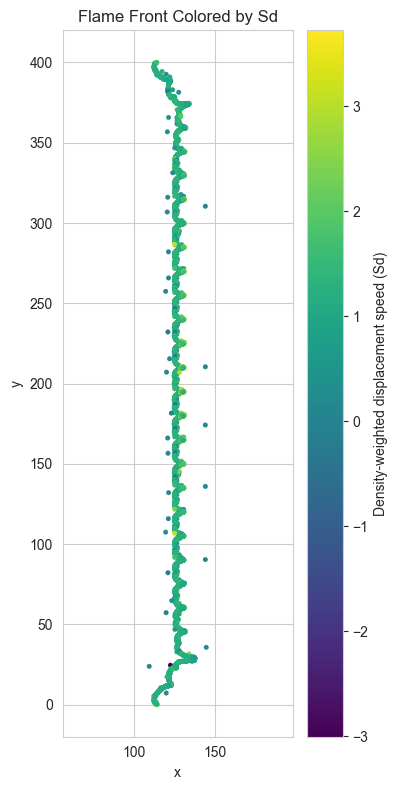

In [18]:
plt.figure(figsize=(4, 8))

sc = plt.scatter(
    front["x"],
    front["y"],
    c = front["disp_speed_density_weighted"],
    cmap = "viridis",
    s = 12,
    linewidths = 0.1
)

plt.axis("equal")
plt.colorbar(sc, label="Density-weighted displacement speed (Sd)")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Flame Front Colored by Sd")
plt.tight_layout()
plt.show()


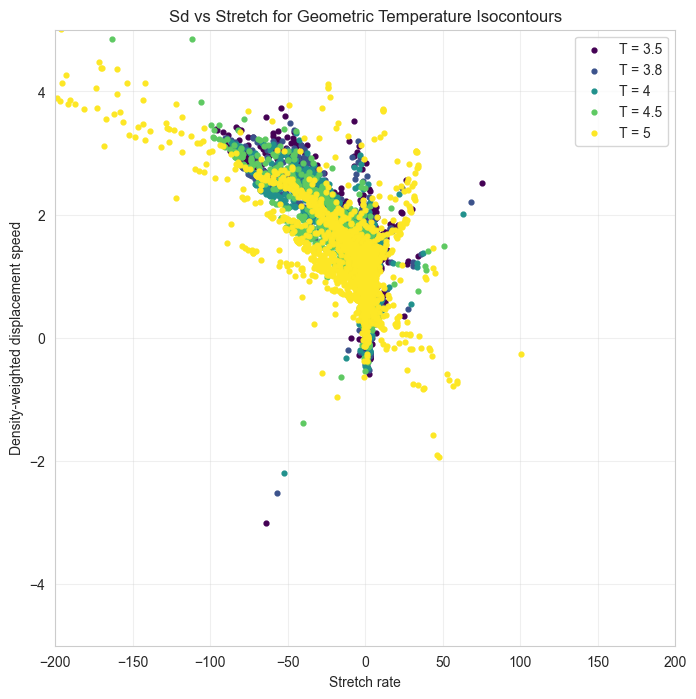

In [19]:
isocon_list = [ 3.5, 3.8, 4, 4.5, 5]

plt.figure(figsize=(8, 8))

cmap = plt.cm.viridis
colors = cmap(np.linspace(0, 1, len(isocon_list)))

for i, iso in enumerate(isocon_list):

    # Extract the flame front for this isocontour
    isoline = ds.extract_flame_front_new(
        sample_mode="isocontour",
        c_level=iso,
    )

    x = isoline["stretch_rate"].to_numpy()
    y = isoline["disp_speed_density_weighted"].to_numpy()

    plt.scatter(x, y, s=12, color=colors[i], label=f"T = {iso}")

    # Fit a line if possible
    # if len(x) > 2:
    #     coeffs = np.polyfit(x, y, deg=1)
    #     x_line = np.linspace(x.min(), x.max(), 200)
    #     y_line = coeffs[0] * x_line + coeffs[1]
    #     plt.plot(x_line, y_line, color=colors[i], linewidth=2)

plt.xlabel("Stretch rate")
plt.ylabel("Density-weighted displacement speed")
plt.ylim((-5, 5))
plt.xlim((-200,200))
plt.title("Sd vs Stretch for Geometric Temperature Isocontours")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


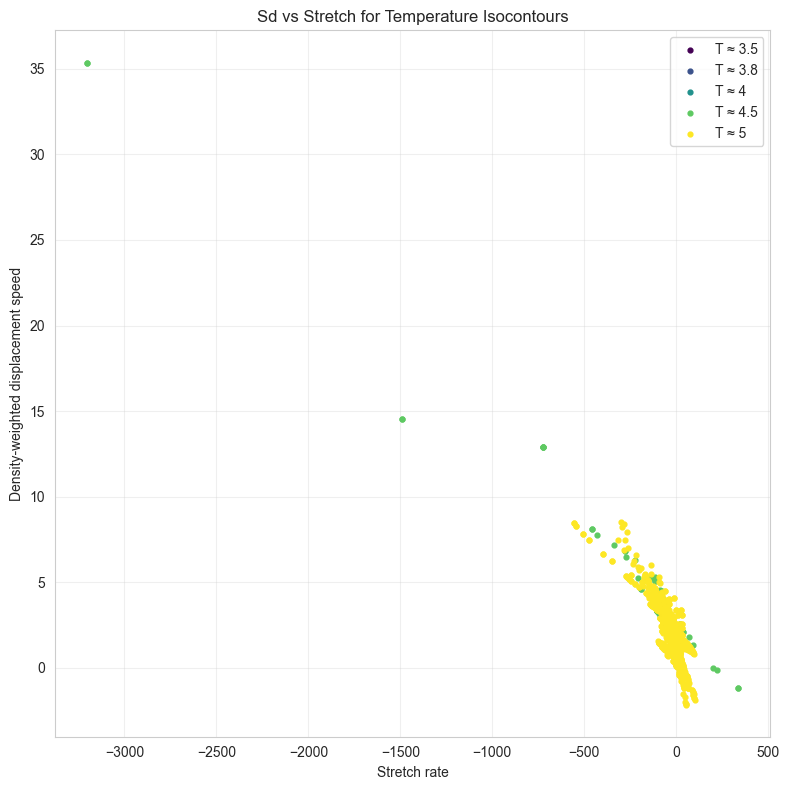

In [20]:
isocon_list = [ 3.5, 3.8, 4, 4.5, 5]
tol = 0.1

plt.figure(figsize=(8, 8))

cmap = plt.cm.viridis  # choose your preferred colormap
colors = cmap(np.linspace(0, 1, len(isocon_list)))

for i, iso in enumerate(isocon_list):
    # Select iso-line slice
    iso_df = df[(df["T"] > (iso - tol)) & (df["T"] < (iso + tol))]

    x = iso_df["stretch_rate"].to_numpy()
    y = iso_df["disp_speed_density_weighted"].to_numpy()

    # Scatter plot
    plt.scatter(x, y, s=12, color=colors[i], label=f"T ≈ {iso}")

    # Fit line if enough points
    # if len(x) > 2:
    #     coeffs = np.polyfit(x, y, deg=1)
    #     x_line = np.linspace(x.min(), x.max(), 200)
    #     y_line = coeffs[0] * x_line + coeffs[1]
    #     plt.plot(x_line, y_line, color=colors[i], linewidth=2)

plt.xlabel("Stretch rate")
plt.ylabel("Density-weighted displacement speed")
plt.title("Sd vs Stretch for Temperature Isocontours")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


